## LECTURA DEL CONJUNTO DE DATOS

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Cargar los datos del archivo template_session.txt
data_path = '../data/s3/e1/u2/template_session.txt'
template = pd.read_csv(data_path,sep=';')
template.head()

,time index,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
0,1,-9.719184,-0.790440,-0.203261,0.002123,0.012305,-0.025375,0.690739,-0.312159,0.282479
1,2,-9.704595,-0.864619,-0.211095,-0.007823,0.023268,-0.014493,0.690705,-0.313595,0.281803
2,3,-9.622469,-0.857694,-0.255200,-0.016215,0.000453,0.018432,0.692023,-0.311737,0.281020
3,4,-9.741556,-0.841768,-0.293310,0.002101,0.030621,0.007372,0.693147,-0.312557,0.281619
4,5,-9.696672,-0.805084,-0.292731,-0.012379,0.031608,0.005529,0.691890,-0.313454,0.281027


In [7]:
# Obtener las velocidades en los ejes x, y, y z
v_x = template['acc_x']
v_y = template['acc_y']
v_z = template['acc_z']

# Calcular la velocidad resultante
v_resultante = np.sqrt(v_x**2 + v_y**2 + v_z**2)

# Agregar la velocidad resultante al DataFrame
template['v_resultante'] = v_resultante

# Mostrar el DataFrame con la nueva columna de velocidad resultante
template[['time index', 'v_resultante']].head()

,time index,v_resultante
0,1,9.753392
1,2,9.745322
2,3,9.663989
3,4,9.782255
4,5,9.734439


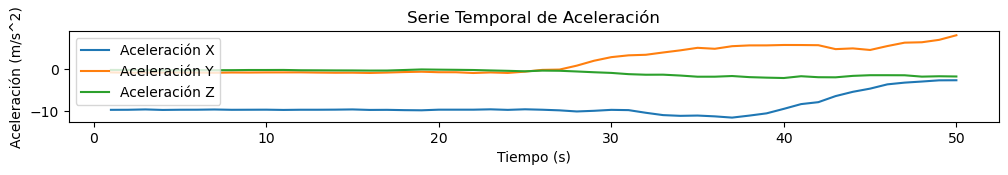

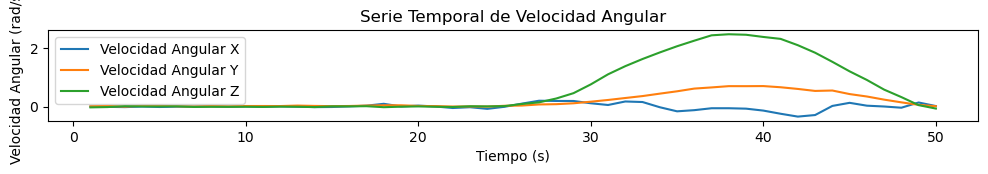

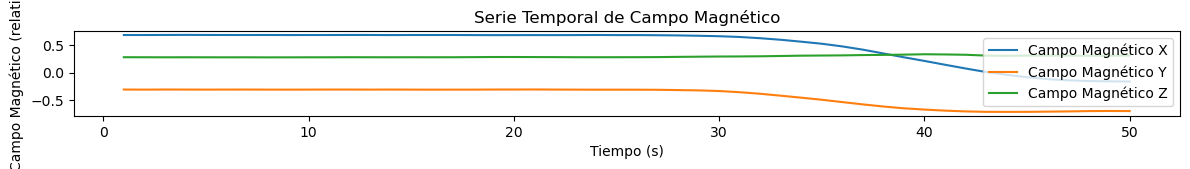

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar los datos del archivo template_session.txt
data_path = '../data/s3/e1/u2/template_session.txt'
data = np.loadtxt(data_path, delimiter=';', skiprows=1)

# Obtener las columnas relevantes
time = data[:, 0]
acceleration = data[:, 1:4]  # Columnas 1 a 3 para aceleración (x, y, z)
angular_rate = data[:, 4:7]  # Columnas 4 a 6 para velocidad angular (x, y, z)
magnetic_field = data[:, 7:10]  # Columnas 7 a 9 para campo magnético (x, y, z)

# Filtrar datos para los primeros 300 segundos
time_limit = 50
mask = time <= time_limit
time = time[mask]
acceleration = acceleration[mask, :]
angular_rate = angular_rate[mask, :]
magnetic_field = magnetic_field[mask, :]

# Graficar la serie temporal de aceleración
plt.figure(figsize=(12, 4))
plt.subplot(3, 1, 1)
plt.plot(time, acceleration[:, 0], label='Aceleración X')
plt.plot(time, acceleration[:, 1], label='Aceleración Y')
plt.plot(time, acceleration[:, 2], label='Aceleración Z')
plt.title('Serie Temporal de Aceleración')
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración (m/s^2)')
plt.legend()

# Graficar la serie temporal de velocidad angular
plt.figure(figsize=(12, 4))
plt.subplot(3, 1, 2)
plt.plot(time, angular_rate[:, 0], label='Velocidad Angular X')
plt.plot(time, angular_rate[:, 1], label='Velocidad Angular Y')
plt.plot(time, angular_rate[:, 2], label='Velocidad Angular Z')
plt.title('Serie Temporal de Velocidad Angular')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Angular (rad/s)')
plt.legend()

# Graficar la serie temporal de campo magnético
plt.figure(figsize=(12, 4))
plt.subplot(3, 1, 3)
plt.plot(time, magnetic_field[:, 0], label='Campo Magnético X')
plt.plot(time, magnetic_field[:, 1], label='Campo Magnético Y')
plt.plot(time, magnetic_field[:, 2], label='Campo Magnético Z')
plt.title('Serie Temporal de Campo Magnético')
plt.xlabel('Tiempo (s)')
plt.ylabel('Campo Magnético (relative)')    
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
from fastdtw.fastdtw import fastdtw

def SDTW(template, y):
    _, path = fastdtw(template, y)
    m1, m2 = path[0]
    return _, m1, m2

def MTMM_DTW(x, y, templates, threshold):
    K = len(templates)
    M = len(y)
    N = [len(template) for template in templates]
    Mleft = [M] * K
    y_tilde = [np.copy(y) for _ in range(K)]

    matches = []

    while any(Mleft[k] >= threshold * N[k] for k in range(K)):
        SDTW_distances = []
        m1_values = []
        m2_values = []

        for k in range(K):
            SDTW_dist, m1, m2 = SDTW(templates[k], y_tilde[k])
            SDTW_distances.append(SDTW_dist)
            m1_values.append(m1)
            m2_values.append(m2)

        k_star = np.argmin([dist / N[k] for k, dist in enumerate(SDTW_distances)])

        if m2_values[k_star] - m1_values[k_star] + 1 >= threshold * N[k_star]:
            matches.append((k_star, m1_values[k_star], m2_values[k_star]))

            for k in range(K):
                y_tilde[k][m1_values[k_star]:m2_values[k_star] + 1] = 100 # Use large integer value

        else:
            y_tilde[k_star][m1_values[k_star]:m2_values[k_star] + 1] = 100 # Use large integer value

        Mleft = [np.sum(y_tilde[k] < np.iinfo(np.int64).max) for k in range(K)]

    return matches

# Example usage
# Assuming you have loaded the template and test sequences as numpy arrays
template1 = np.array([1, 2, 3, 4, 5])
template2 = np.array([5, 4, 3, 2, 1])
template3 = np.array([1, 2, 1, 2, 1])

test_sequence = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5])

templates = [template1, template2, template3]
threshold_value = 0.5  # Adjust the threshold as needed

matches = MTMM_DTW(test_sequence, test_sequence, templates, threshold_value)
print("Matches:", matches)


KeyboardInterrupt: 